# **<span style="color:red">Imports</span>**

In [1]:
import math

# Handy arrays
import numpy as np

# Image utils
import cv2

# File operations
import os

# FFTs
import scipy.fft as fft
import scipy.fftpack as fftp

# Plotting
import matplotlib

# Custom modules
import lib.utils.utils as Utils
import lib.utils.plotting as Plotting

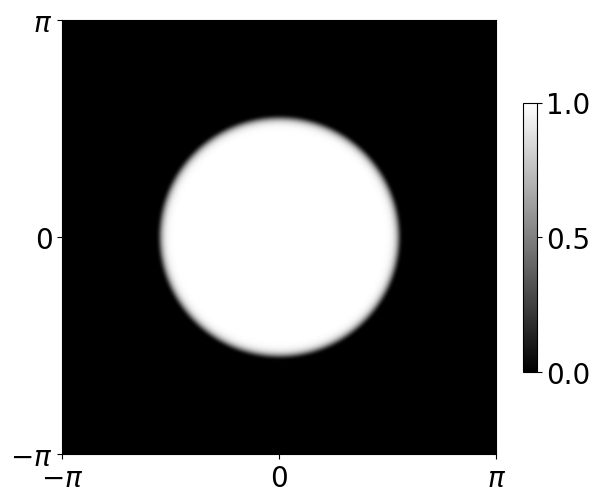

In [2]:
window_func = Utils.create_super_gauss((1024,1024), 0.55, 7)
Plotting.plot_image(window_func)

# <span style="color:red">**Spectrum analysis**</span>

In [3]:
def analyse_image_spectrum(path: str, save_path: str, bg_clp=0.1, contrast=1.3, brightness=-10):
    """Analyses image spectrum.
    """

    # Different slicing and window functions for different image types
    if path.find('Fundus') != -1:
        im = Utils.image_load(path, cropping = (slice(44, 871), slice(322, 1149)))
        window_func = Utils.create_super_gauss(im.shape, 9/11, 7)
        threshold = 0.25
    elif path.find('СЛО') != -1:
        im = Utils.image_load(path, cropping = (slice(0, 768), slice(0, 768)))
        window_func = Utils.create_super_gauss(im.shape, 10/11, 7, mode='square')
        threshold = 0.25
    else:
        im = Utils.image_load(path)
        window_func = Utils.create_super_gauss(im.shape, 10/11, 7, mode='square')
        threshold = 0.47
    
    # Apply window function for better spectrum
    im = im * window_func

    # Image FFT and spectrum
    im_fft = fft.fft2(im)
    im_spectrum = fftp.fftshift(Utils.get_spectrum(im_fft))

    # Find, where spectrum energy is > defined threshold in %
    most_energy = im_spectrum > (threshold * im_spectrum.max())
    # Find radius of those points
    X, Y = Utils.create_matrix_grid_coordinates(most_energy.shape)
    rad_energy = np.sqrt(most_energy * (X**2 + Y**2))
    # Clamp by 3/4 pi
    a = rad_energy * (rad_energy < math.pi * 3/4)
    # Compute histogram for these values
    histogram, bin_edges = np.histogram(a, bins=np.unique(a)[1:])

    #rad = (X**2 + Y**2)
    #total_energy = 0.75 * np.sum(im_spectrum)
    #R = 0
    #for r in np.unique(X**2):
    #    R = r
    #    if np.sum((rad < r) * im_spectrum) > total_energy:
    #        break
    #with open(save_path.replace('.png', '.txt'), "w") as file:
    #    file.write("Radius: {:.2f}\n".format(R/(math.pi**2)))

    # Spectrum enhancement
    enhanced_spectrum_1 = Utils.image_normalize(im_spectrum - bg_clp * im_spectrum.max())
    enhanced_spectrum_2 = cv2.convertScaleAbs(enhanced_spectrum_1 * 255, alpha=contrast, beta=brightness)

    # Save images
    Utils.image_save(im, save_path.replace('.png', '_1.png'))
    Utils.image_save(enhanced_spectrum_2, save_path.replace('.png', '_2.png'))
    Utils.image_save(most_energy, save_path.replace('.png', '_3.png'))
    # Plot histogram
    Plotting.plot_functions([Plotting.FuncDesc((bin_edges[:-1])/math.pi, histogram, 'Histogram', 'r')],
                             x_axis_name=r'$\lambda, nm$', plot_file=save_path.replace('.png', '_4.png'))
    matplotlib.pyplot.close()

In [4]:
def process_all_files(source_dir: str, output_dir: str, function: callable):
    """
    Aplies profided function to all files in a given directory and its subdirectories.

    Args:
        source_dir (str): The path to the root directory to start the iteration.
    """
    for dirpath, dirnames, filenames in os.walk(source_dir):
        # dirpath: The current directory path os.walk is visiting.
        # dirnames: A list of subdirectory names in the current dirpath.
        # filenames: A list of file names in the current dirpath.

        for filename in filenames:
            full_file_path = os.path.join(dirpath, filename)
            function(full_file_path, output_dir + full_file_path.removeprefix(source_dir).split('.')[0] + '.png')

In [5]:
def remove_images(path: str, save_path: str, file_endings: list[str]):
    for file_ending in file_endings:
        path = save_path.replace('.png', file_ending)
        if os.path.exists(path):
            os.remove(path)

In [6]:
def process_images(source_dir: str, output_dir: str, function: callable):
    process_all_files(source_dir, output_dir, function)

In [7]:
process_images('Samples/Anns Article', 'Results_(Anns_Article)', analyse_image_spectrum)